In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
!nvidia-smi

Wed Nov 16 12:33:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import os
from PIL import Image
import numpy as np

import tensorflow as tf
from tensorflow import keras
from keras import layers

# Load the TensorBoard notebook extension
%load_ext tensorboard
import datetime

# Required to save models in HDF5 format
!pip install pyyaml h5py  

print(tf.__version__)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2.9.2


In [4]:
# Clear any logs from previous runs
!rm -rf ./logs/

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpu = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)

# Load Datas

SyntaxError: ignored

# Build Model

Model: "unet4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder0 (Encoder)          ((None, 256, 256, 32),    9696      
                              (None, 512, 512, 32))              
                                                                 
 encoder1 (Encoder)          ((None, 128, 128, 64),    55680     
                              (None, 256, 256, 64))              
                                                                 
 encoder2 (Encoder)          ((None, 64, 64, 128),     221952    
                              (None, 128, 128, 128))             
                                                                 
 encoder3 (Encoder)          ((None, 32, 32, 256),     886272    
                              (None, 64, 64, 256))               
                                                                 
 decoder0 (Decoder)          (None, 512, 512, 32)      46176 

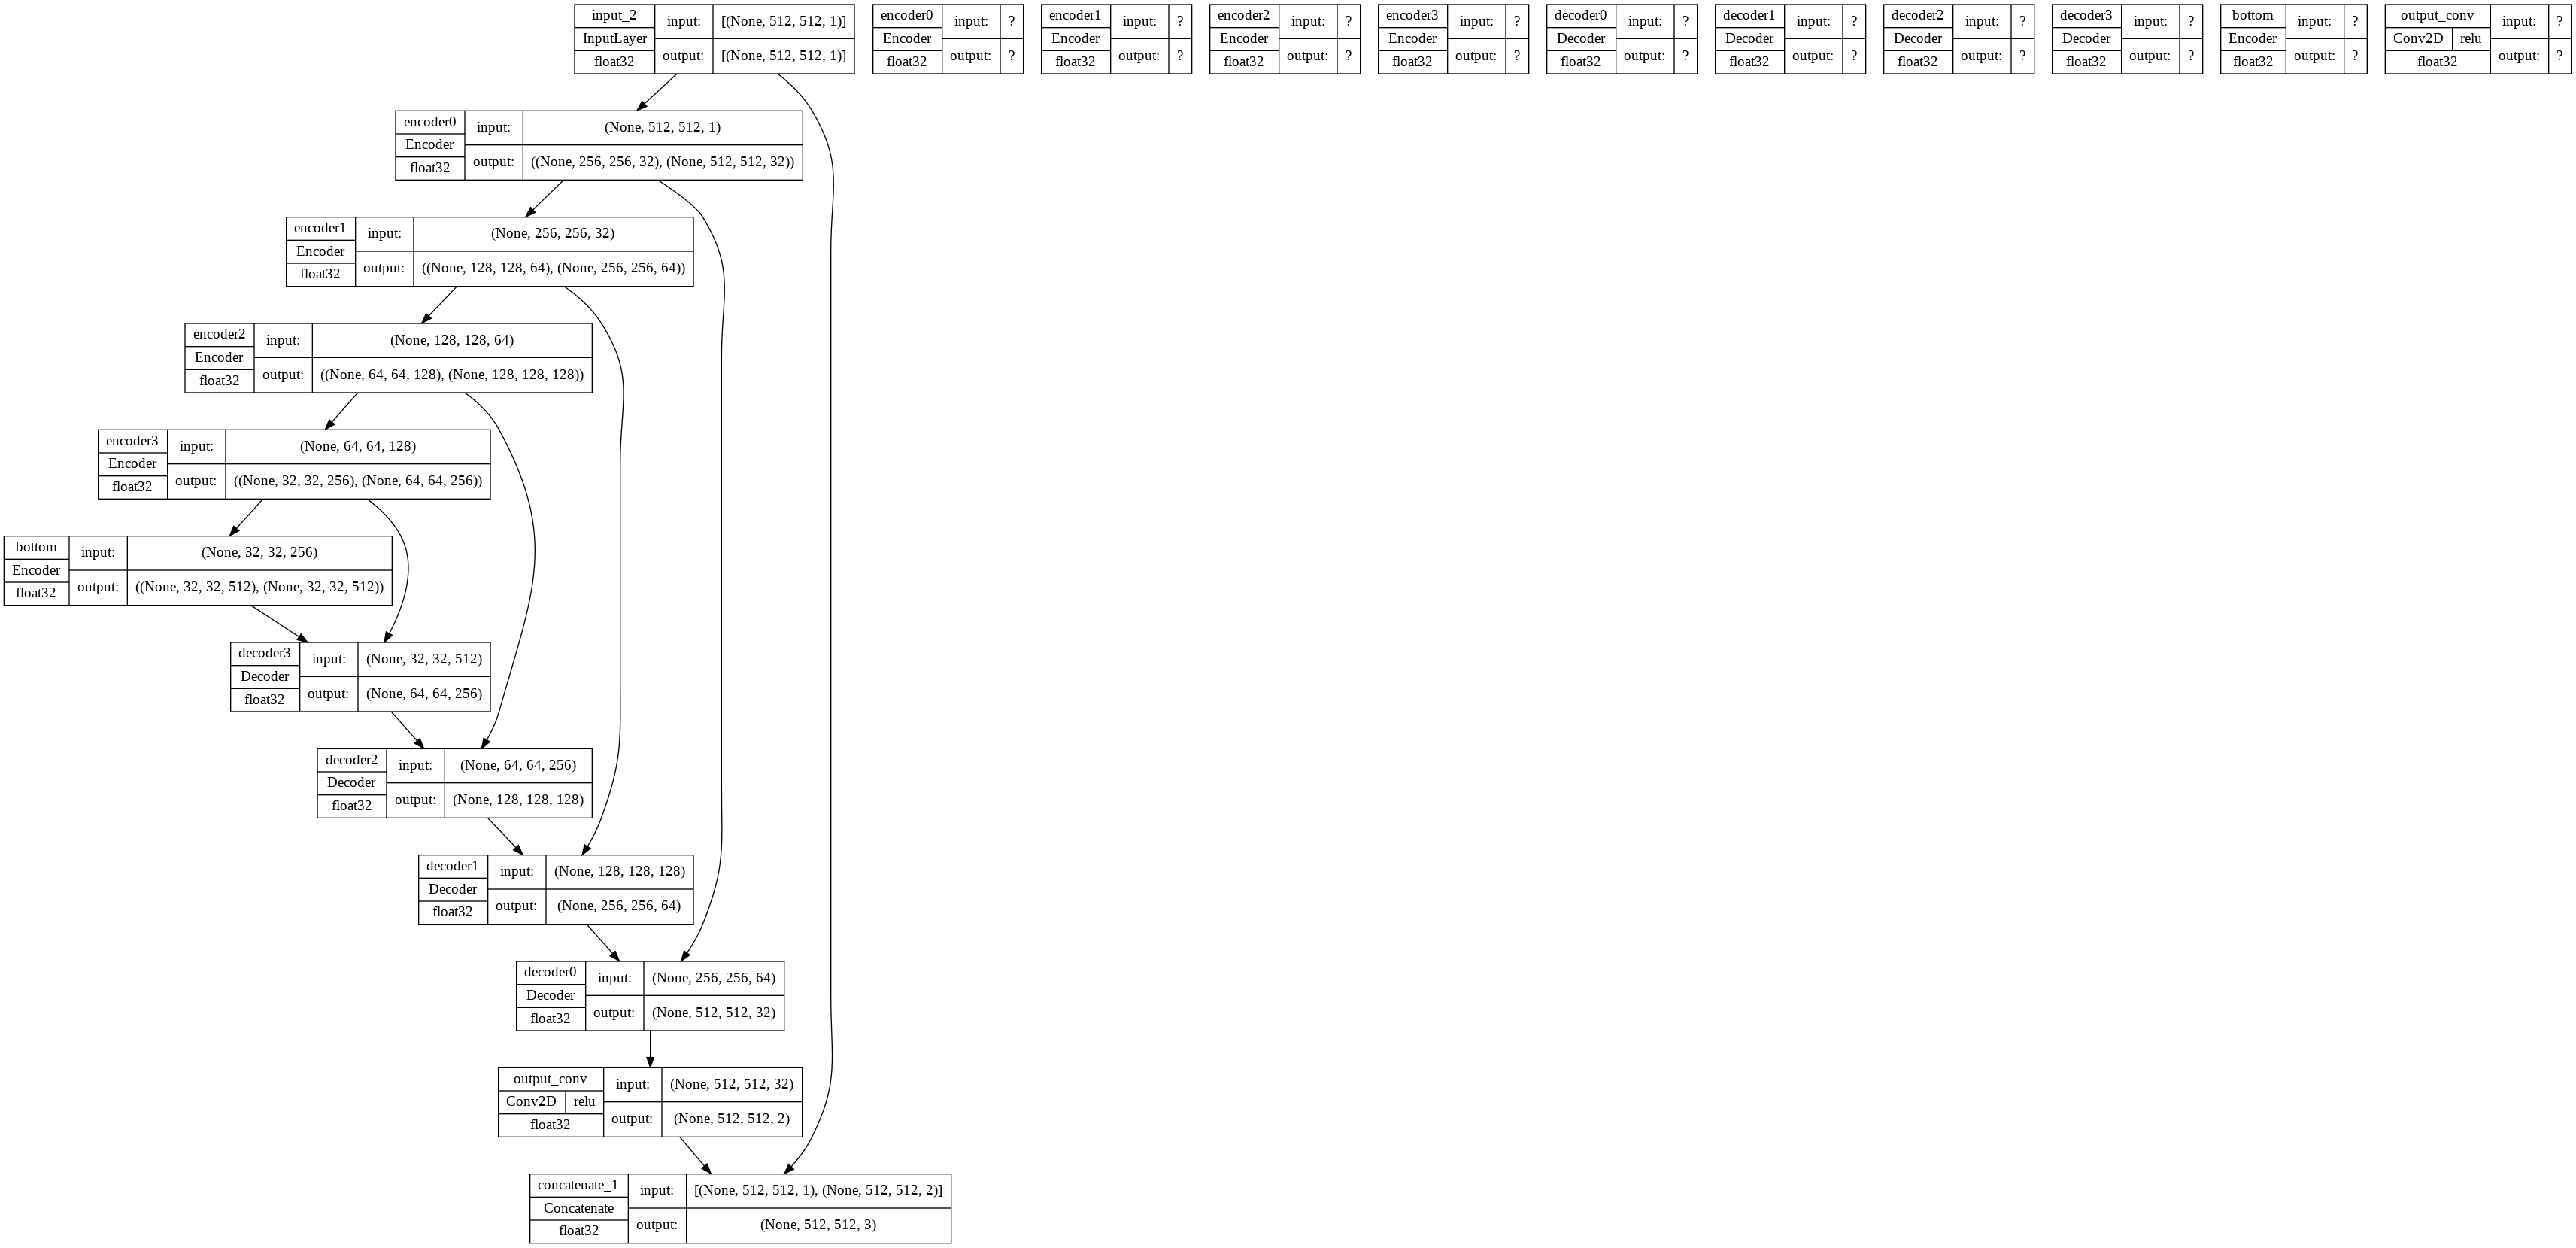

In [35]:
#@title Build Model {vertical-output: true, display-mode: "form" }
model_name = "unet4" #@param {type:"string"}
depth = 4 #@param {type:"integer"}
dropout_prob = 0.3 #@param {type:"number"}
n_filters = 32 #@param {type:"integer"}


#@markdown ---

class Encoder(layers.Layer):

  def __init__(self, n_filters=32, name="encoder", dropout_prob=0.3, max_pooling=True, **kwargs):
      super(Encoder, self).__init__(name=name, **kwargs)

      self.conv1 = tf.keras.layers.Conv2D(n_filters, 
                3,  
                activation='relu',
                padding='same',
                kernel_initializer='HeNormal')
      self.conv2 = tf.keras.layers.Conv2D(n_filters, 
                3,  
                activation='relu',
                padding='same',
                kernel_initializer='HeNormal')
      
      self.drop = tf.keras.layers.Dropout(dropout_prob)

      self.max_pooling_layer = tf.keras.layers.MaxPooling2D(
          pool_size = (2,2),
          padding='same')
      
      self.max_pooling = max_pooling

      self.norm = tf.keras.layers.BatchNormalization()


  def call(self, inputs, training=False):

      conv1 = self.conv1(inputs)
      conv2 = self.conv2(conv1)

      norm = self.norm(conv2, training=training)

      drop = self.drop(norm, training=training)

      if self.max_pooling :
        next_layer = self.max_pooling_layer(drop)  
      else:
        next_layer = drop

      skip_connection = drop

      return next_layer, skip_connection
      
class Decoder(layers.Layer):

    def __init__(self, n_filters=32, name="decoder", **kwargs):
        super(Decoder, self).__init__(name=name, **kwargs)

        self.up = tf.keras.layers.Conv2DTranspose(
                 n_filters,
                 (3,3),
                 strides=(2,2),
                 padding='same')

        self.conv1 = tf.keras.layers.Conv2D(n_filters, 
                 3,  
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')
        
        self.conv2 = tf.keras.layers.Conv2D(n_filters, 
                 3,  
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')

    def call(self, inputs, skip_layer_inputs):

        up = self.up(inputs)
        merge = tf.keras.layers.concatenate([up, skip_layer_inputs], axis=-1)
        conv1 = self.conv1(merge)
        conv2 = self.conv2(conv1)

        return conv2

class Unet(tf.keras.Model):

  def __init__(
        self,
        inputshape = (512, 512, 1),
        depth = 4,
        dropout_prob = 0.3,
        n_filters = 64,
        name = "unet",
        **kwargs
    ):
    super(Unet, self).__init__(name=name, **kwargs)

    self.inputshape = inputshape
    self.depth = depth

    self.encoders = []
    self.decoders = []

    for i in range(depth):
      self.encoders.append(Encoder(name = 'encoder'+ str(i), n_filters=n_filters * (2**i) , dropout_prob=dropout_prob, max_pooling=True))
      self.decoders.append(Decoder(name = 'decoder'+ str(i), n_filters=n_filters * (2**i)))
      
    self.bottom_layer = Encoder(name = 'bottom', n_filters=n_filters * (2**depth) , dropout_prob=dropout_prob, max_pooling=False)

    self.outConv = tf.keras.layers.Conv2D(
                 2, 
                 3,
                 name='output_conv',
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')

  def call(self, inputs, training=False):

    skips = []

    encoder = inputs

    for i in range(self.depth):
      encoder, skip = self.encoders[i](encoder, training=training)
      skips.append(skip)

    decoder, _ = self.bottom_layer(encoder, training=training)

    for i in reversed(range(self.depth)):
      decoder = self.decoders[i](decoder, skips[i])

    # How to get 2 layers on the output ? Deep layer of size 2* output image size then cut in 2 ?
    prediction = self.outConv(decoder)
    output = tf.keras.layers.concatenate([inputs, prediction], axis=-1)
    return output

  def model(self):
        x = tf.keras.layers.Input(shape=self.inputshape)
        return Unet(inputs=[x], outputs=self.call(x))



tf.keras.backend.clear_session()

model = Unet(depth=depth, 
             dropout_prob=dropout_prob, 
             n_filters=n_filters, 
             name=model_name)

# 2**depth MINIMUM
model.build(input_shape=(None, 512, 512, 1))

#Process some data before, build is not enought
tf.keras.utils.plot_model(
    model.model(),
    to_file='model.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=96,
    layer_range=None,
    show_layer_activations=True
)

model.summary()

# Don't ask
tf.keras.utils.plot_model(
    model.model(),
    to_file='model.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=96,
    layer_range=None,
    show_layer_activations=True
)

# Learning

In [20]:
#@title Parameters { run: "auto", display-mode: "form" }

#@markdown ### Learning Parameters
batch_size = 32 #@param {type:"integer"}
epochs = 5 #@param {type:"integer"}
learning_rate = 1e-3 #@param {type:"number"}

#@markdown ---
#@markdown ### Loading Model
load_model = False #@param {type:"boolean"}
load_latest = True #@param {type:"boolean"}
load_path = "learning1/unet.ckpt" #@param {type:"string"}

#@markdown ---
#@markdown ### Saving Model
save_model = True #@param {type:"boolean"}
checkpoint_path = "learning1/unet.ckpt" #@param {type:"string"}
checkpoint_dir = os.path.dirname(checkpoint_path)
save_every_x_epochs = 5 #@param {type:"integer"}

callbacks = []

## Start learning

In [ ]:
# Load saved weights
if load_model:
  if load_latest:
    load_path = tf.train.latest_checkpoint(checkpoint_dir)
  model.load_weights(load_path)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# loss_metric = tf.keras.metrics.Mean()
loss_metric = ['accuracy']

model.compile(optimizer=optimizer, loss=loss, metrics=loss_metric)

In [ ]:
if save_model:
  #Save the model

  # Create a callback that saves the model's weights
  save_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                  save_weights_only=True,
                                                  verbose=1,
                                                  save_freq=save_every_x_epochs*batch_size) #Every 5 epoch
  callbacks.append(save_callback)

In [ ]:
# Tensor Board callback
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
callbacks.append(tensorboard_callback)

In [ ]:
results = model.fit(
          x=x_train, 
          y=y_train,
          batch_size=batch_size,
          epochs=epochs, 
          validation_data=(x_valid, y_valid), 
          callbacks=callbacks)

# Show results

In [ ]:
%tensorboard --logdir logs/fit

In [ ]:
#show graphs